In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py
import re

from collections import defaultdict
from scipy.stats import ttest_ind

FPS = 60

## Load data

In [70]:
# Path to the .h5 file
file_path = '../syllable_analyses_julia_11_vids/results.h5'

# Initialize a dictionary to hold dfs for each Mouse ID
include_latent_state = False

# Using defaultdict in case there are multiple groups per Mouse ID
dfs = defaultdict(list)

# Regular expression pattern to extract Mouse ID
# Assumes Mouse ID is the number before 'DLC' in the group name
mouse_id_pattern = re.compile(r'_(\d+)DLC_')

with h5py.File(file_path, 'r') as file:
    for group_name in file.keys():
        # Extract Mouse ID using regex
        match = mouse_id_pattern.search(group_name)
        if match:
            mouse_id = match.group(1)
        else:
            # Handle cases where Mouse ID is not found
            print(f"Warning: Mouse ID not found in group name '{group_name}'. Skipping this group.")
            continue  # Skip this group
        
        # Check if Mouse ID already exists in the dictionary (this would indicate an error)
        if mouse_id in dfs:
            raise ValueError(f"Error: Multiple groups found for Mouse ID '{mouse_id}' in the file. Only one group per Mouse ID is expected.")
        
        group = file[group_name]
        
        # List to hold individual DataFrames for each dataset
        df_list = []
        
        for dataset_name in group.keys():
            # Exclude 'latent_state' datasets if the flag is False
            if not include_latent_state and dataset_name.startswith('latent_state'):
                continue
            
            dataset = group[dataset_name][:]
            
            # Check if dataset is at least 1D
            if dataset.ndim == 1:
                # Convert to 2D array with one column
                dataset = dataset.reshape(-1, 1)
            
            # Create column names by appending index to dataset name
            # Example: 'centroid_0', 'centroid_1', ...
            num_cols = dataset.shape[1]
            columns = [f"{dataset_name}_{i}" for i in range(num_cols)]
            
            # Convert dataset to DataFrame
            df = pd.DataFrame(dataset, columns=columns)
            df_list.append(df)
        
        if df_list:
            # Concatenate all DataFrames horizontally (axis=1)
            concatenated_df = pd.concat(df_list, axis=1)
            # Add to the dictionary with the Mouse ID as the key
            dfs[mouse_id] = concatenated_df
        else:
            print(f"Warning: No datasets found in group '{group_name}'.")

## Prepare data

In [71]:
for df in dfs.values():
    df['timestamp'] = df.index / FPS
    df['current_minute'] = df['timestamp'] / 60

In [72]:
syllable_info = pd.read_csv('../syllable_analyses_julia_11_vids/syllable,behavior_group_dim4.csv', index_col=0)
#pd.read_csv('../syllable_analysis_julia/syllable,behavior.csv', index_col=0)
#syllable_info.loc[41] = 'faulty'

syllable_map = syllable_info.to_dict()['behavior']

mouse_info = pd.read_csv('../syllable_analysis_cohort2/syllables_mouseCoh2_info.csv', index_col=0)

In [73]:
for df in dfs.values():
    df['syllable_name'] = df['syllable_0'].map(syllable_map)
    df['syllable_name'] = df['syllable_name'].fillna('misc')  # Replace NaN with 'faulty'

## Split by injection

In [74]:
def split_df_by_injection(df, mouse_id):
    # Get the relevant time intervals from the mouse_info DataFrame
    pre_inj_start, pre_inj_end, post_inj_start, post_inj_end = \
        mouse_info.loc[mouse_id][['PreInjStart', 'PreInjEnd', 'PostInjStart', 'PostInjEnd']].to_list()

    post_inj_end -= 30
    # Filter DataFrame based on the current_minute column for pre-injection
    pre_inj_df = df[(np.floor(df['current_minute']) >= pre_inj_start) & (np.ceil(df['current_minute']) <= pre_inj_end)]
    
    # Filter DataFrame based on the current_minute column for post-injection
    post_inj_df = df[(np.floor(df['current_minute']) >= post_inj_start) & (np.ceil(df['current_minute']) <= post_inj_end)]

    return pre_inj_df, post_inj_df

In [75]:
# dfs_split = defaultdict(list)

# for mouse_id, df in dfs.items():
#     genotype, side = list(mouse_info.loc[int(mouse_id)])[:2]
#     pre_inj_df, post_inj_df = split_df_by_injection(df, int(mouse_id))

#     dfs_split[(mouse_id, 'pre', genotype, side)] = pre_inj_df
#     dfs_split[(mouse_id, 'post', genotype, side)] = post_inj_df

dfs_split = defaultdict(list)

for mouse_id, df in dfs.items():
    genotype, _ = list(mouse_info.loc[int(mouse_id)])[:2]
    pre_inj_df, post_inj_df = split_df_by_injection(df, int(mouse_id))

    dfs_split[(mouse_id, 'pre', genotype)] = pre_inj_df
    dfs_split[(mouse_id, 'post', genotype)] = post_inj_df

In [76]:
for k, v in dfs_split.items():
    print(k, len(v))

('222', 'pre', 'Het') 216001
('222', 'post', 'Het') 216001
('214', 'pre', 'WT') 212401
('214', 'post', 'WT') 216001
('237', 'pre', 'Het') 216001
('237', 'post', 'Het') 216001
('218', 'pre', 'Het') 216001
('218', 'post', 'Het') 216001
('210', 'pre', 'WT') 216001
('210', 'post', 'WT') 216001
('239', 'pre', 'Het') 216001
('239', 'post', 'Het') 216001
('220', 'pre', 'Het') 216001
('220', 'post', 'Het') 216001
('206', 'pre', 'WT') 216001
('206', 'post', 'WT') 216001
('243', 'pre', 'WT') 216001
('243', 'post', 'WT') 216001
('208', 'pre', 'WT') 216001
('208', 'post', 'WT') 216001
('202', 'pre', 'Het') 216001
('202', 'post', 'Het') 216001


## Calculate angular parameters

In [77]:
def compute_angular_velocity(df):
    # Unwrap the heading angles to prevent discontinuities
    df.loc[:, 'unwrapped_heading'] = np.unwrap(df['heading_0'])  # Use .loc[] to avoid the warning
    # Compute time differences
    df.loc[:, 'time_diff'] = df['timestamp'].diff().fillna(0)
    # Compute heading differences
    df.loc[:, 'heading_diff'] = df['unwrapped_heading'].diff().fillna(0)
    # Compute angular velocity
    df.loc[:, 'angular_velocity'] = df['heading_diff'] / df['time_diff']
    return df

In [78]:
# Apply the function to all DataFrames in dfs
for key, df in dfs.items():
    dfs[key] = compute_angular_velocity(df)  # Reassign the result to the original DataFrame

# Apply the function to all DataFrames in dfs_split
for key, df in dfs_split.items():
    dfs_split[key] = compute_angular_velocity(df)  # Reassign the result to the original DataFrame


/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_88055/579445921.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_88055/579445921.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_88055/579445921.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [79]:
def remove_outliers_zscore_replace(df, threshold=3):
    # Calculate mean and standard deviation
    mean = df['angular_velocity'].mean()
    std = df['angular_velocity'].std()
    
    # Define upper and lower bounds based on the threshold
    upper_bound = mean + threshold * std
    lower_bound = mean - threshold * std
    
    # Replace outliers with the upper or lower bound using .loc[] to avoid warnings
    df.loc[:, 'angular_velocity_clean'] = df['angular_velocity'].clip(lower=lower_bound, upper=upper_bound)
    
    return df

In [80]:
# Apply the function to all DataFrames in dfs
for key, df in dfs.items():
    dfs[key] = remove_outliers_zscore_replace(df, threshold=3)

# Apply the function to all DataFrames in dfs_split
for key, df in dfs_split.items():
    dfs_split[key] = remove_outliers_zscore_replace(df, threshold=3)

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_88055/1311355301.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_88055/1311355301.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/mx/4x3wkj053dg1gcmc9yq87kw00000gn/T/ipykernel_88055/1311355301.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [81]:
for k, df in dfs_split.items():
    print(k, -df['angular_velocity_clean'].sum()/6.28)

('222', 'pre', 'Het') 150.15414529147913
('222', 'post', 'Het') 23055.842434587725
('214', 'pre', 'WT') 587.7723354005958
('214', 'post', 'WT') 9227.0442767107
('237', 'pre', 'Het') -658.2312088016782
('237', 'post', 'Het') 15166.972106393101
('218', 'pre', 'Het') -1223.6820108327202
('218', 'post', 'Het') -2923.220125191042
('210', 'pre', 'WT') -1016.1223863404452
('210', 'post', 'WT') -6451.557766708725
('239', 'pre', 'Het') -376.9147466972052
('239', 'post', 'Het') -1452.0122942762603
('220', 'pre', 'Het') -1108.3380057134334
('220', 'post', 'Het') -7698.065419479569
('206', 'pre', 'WT') -666.8991068005895
('206', 'post', 'WT') -5044.927123049851
('243', 'pre', 'WT') 712.7580735931842
('243', 'post', 'WT') -11649.438161097361
('208', 'pre', 'WT') -774.5960393411093
('208', 'post', 'WT') 3126.094411747425
('202', 'pre', 'Het') 535.5501788682391
('202', 'post', 'Het') 27715.343133089693


In [83]:
grouped_rotations = defaultdict(list)

for k, df in dfs_split.items():
    grouped_rotations[k[1:]].append(-df['angular_velocity_clean'].sum()/6.283)

for k, lst in grouped_rotations.items():
    grouped_rotations[k] = sum(lst) / len(lst)

for k, v in grouped_rotations.items():
    print(k, v)

('pre', 'Het') -446.6968844161441
('post', 'Het') 8973.190083414944
('pre', 'WT') -231.3069277576611
('post', 'WT') -2157.526207094008


## transition analysis

### transition matrices

In [84]:
def create_transition_matrix_exclude_faulty(dfs_split, faulty_syllable, column='syllable_name'):
    all_syllables = set()

    # Step 1: Collect all unique syllables across all DataFrames, excluding the faulty syllable
    for df in dfs_split.values():
        all_syllables.update(df[column].unique())
    
    # Remove the faulty syllable from the set
    all_syllables.discard(faulty_syllable)

    all_syllables = sorted(list(all_syllables))  # Convert to a sorted list for consistent ordering
    
    # Step 2: Use defaultdict to store transition matrices
    all_transition_matrices = defaultdict(list)
    
    for k, df in dfs_split.items():
        # Remove rows that have the faulty syllable
        filtered_df = df[(df[column] != faulty_syllable)]

        # Remove consecutive duplicates
        filtered_df = filtered_df[filtered_df[column] != filtered_df[column].shift()]

        # Create an empty DataFrame for the transition matrix with all valid syllables
        transition_matrix = pd.DataFrame(0, index=all_syllables, columns=all_syllables)

        # Get transitions using shift
        transitions = pd.DataFrame({
            'current_syllable': filtered_df[column],
            'next_syllable': filtered_df[column].shift(-1)
        }).dropna()

        # Count transitions
        transition_counts = transitions.groupby(['current_syllable', 'next_syllable']).size()

        # Populate the transition matrix with raw counts
        for (current, next_), count in transition_counts.items():
            transition_matrix.loc[current, next_] += count

        # Store the raw transition matrix in the defaultdict
        all_transition_matrices[k] = transition_matrix

    return all_transition_matrices

In [85]:
# Assuming dfs_split is a dictionary of DataFrames and 'Faulty' is the faulty syllable
faulty_syllable = 'misc'

# Create transition matrices excluding the faulty syllable
all_transition_matrices = create_transition_matrix_exclude_faulty(dfs_split, faulty_syllable)

In [86]:
all_transition_matrices.keys()

dict_keys([('222', 'pre', 'Het'), ('222', 'post', 'Het'), ('214', 'pre', 'WT'), ('214', 'post', 'WT'), ('237', 'pre', 'Het'), ('237', 'post', 'Het'), ('218', 'pre', 'Het'), ('218', 'post', 'Het'), ('210', 'pre', 'WT'), ('210', 'post', 'WT'), ('239', 'pre', 'Het'), ('239', 'post', 'Het'), ('220', 'pre', 'Het'), ('220', 'post', 'Het'), ('206', 'pre', 'WT'), ('206', 'post', 'WT'), ('243', 'pre', 'WT'), ('243', 'post', 'WT'), ('208', 'pre', 'WT'), ('208', 'post', 'WT'), ('202', 'pre', 'Het'), ('202', 'post', 'Het')])

In [87]:
# grouped_transitions = defaultdict(list)
grouped_transitions = {}

# Group the transition matrices by key (k[1:3])
for k, transition_matrix in all_transition_matrices.items():
    grouped_transitions[k] = [transition_matrix]
    #grouped_transitions[k[1:4]].append(transition_matrix)

# # Calculate the mean for each group, retaining indices
# for k, transition_matrices in grouped_transitions.items():
#     # Concatenate all matrices into a single DataFrame
#     concatenated = pd.concat(transition_matrices).astype(float).groupby(level=0).mean()
#     # Reassign the averaged transition matrix back to the dictionary
#     grouped_transitions[k] = concatenated

In [88]:
for k, g in grouped_transitions.items():
    print(k, len(g), g[0].shape)

('222', 'pre', 'Het') 1 (10, 10)
('222', 'post', 'Het') 1 (10, 10)
('214', 'pre', 'WT') 1 (10, 10)
('214', 'post', 'WT') 1 (10, 10)
('237', 'pre', 'Het') 1 (10, 10)
('237', 'post', 'Het') 1 (10, 10)
('218', 'pre', 'Het') 1 (10, 10)
('218', 'post', 'Het') 1 (10, 10)
('210', 'pre', 'WT') 1 (10, 10)
('210', 'post', 'WT') 1 (10, 10)
('239', 'pre', 'Het') 1 (10, 10)
('239', 'post', 'Het') 1 (10, 10)
('220', 'pre', 'Het') 1 (10, 10)
('220', 'post', 'Het') 1 (10, 10)
('206', 'pre', 'WT') 1 (10, 10)
('206', 'post', 'WT') 1 (10, 10)
('243', 'pre', 'WT') 1 (10, 10)
('243', 'post', 'WT') 1 (10, 10)
('208', 'pre', 'WT') 1 (10, 10)
('208', 'post', 'WT') 1 (10, 10)
('202', 'pre', 'Het') 1 (10, 10)
('202', 'post', 'Het') 1 (10, 10)


## PCA

In [89]:
grouped_transitions.keys()

dict_keys([('222', 'pre', 'Het'), ('222', 'post', 'Het'), ('214', 'pre', 'WT'), ('214', 'post', 'WT'), ('237', 'pre', 'Het'), ('237', 'post', 'Het'), ('218', 'pre', 'Het'), ('218', 'post', 'Het'), ('210', 'pre', 'WT'), ('210', 'post', 'WT'), ('239', 'pre', 'Het'), ('239', 'post', 'Het'), ('220', 'pre', 'Het'), ('220', 'post', 'Het'), ('206', 'pre', 'WT'), ('206', 'post', 'WT'), ('243', 'pre', 'WT'), ('243', 'post', 'WT'), ('208', 'pre', 'WT'), ('208', 'post', 'WT'), ('202', 'pre', 'Het'), ('202', 'post', 'Het')])

In [93]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

# ----------------------------
# Step 1: Prepare the Data
# ----------------------------

# Initialize lists to collect data and labels
data = []
labels = []

# Iterate over the grouped_transitions dictionary
for key, matrices in grouped_transitions.items():
    for matrix in matrices:
        # Flatten each matrix and append to data
        data.append(matrix.values.flatten())
        # Create a label based on key[1] and key[2]
        labels.append(f'{key[1]} {key[2]}')

# Convert the data list to a NumPy array
data = np.array(data)

# ----------------------------
# Step 2: Standardize the Data
# ----------------------------

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the data and transform the data
data_scaled = scaler.fit_transform(data)

# ----------------------------
# Step 3: Perform PCA
# ----------------------------

# Initialize PCA with 5 components
pca = PCA(n_components=5)

# Fit PCA on the scaled data and transform the data
principal_components = pca.fit_transform(data_scaled)

# ----------------------------
# Step 4: Save the Scaler and PCA Model
# ----------------------------

# Save the fitted scaler to a file
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved to 'scaler.pkl'.")

# Save the fitted PCA model to a file
joblib.dump(pca, 'pca_model.pkl')
print("PCA model saved to 'pca_model.pkl'.")

# ----------------------------
# Step 5: Save the Principal Components
# ----------------------------

# Option 1: Save as a NumPy array
np.save('principal_components.npy', principal_components)
print("Principal components saved to 'principal_components.npy'.")

# Option 2: Save as a Pandas DataFrame (with labels)
pc_columns = [f'PC{i}' for i in range(1, 6)]  # PC1 to PC5
df_pcs = pd.DataFrame(principal_components, columns=pc_columns)
df_pcs['Label'] = labels  # Optional: Include labels for reference
df_pcs.to_csv('principal_components.csv', index=False)
print("Principal components saved to 'principal_components.csv' with labels.")

Scaler saved to 'scaler.pkl'.
PCA model saved to 'pca_model.pkl'.
Principal components saved to 'principal_components.npy'.
Principal components saved to 'principal_components.csv' with labels.


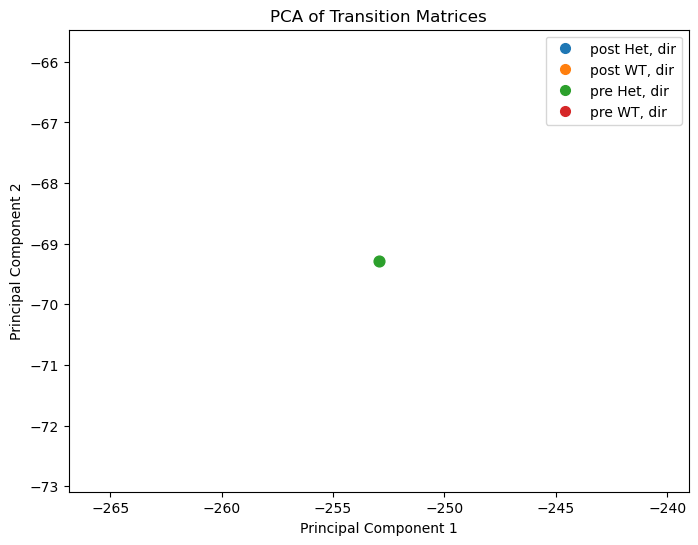

In [92]:
import matplotlib.lines as mlines
from sklearn.decomposition import PCA

# Flatten the matrices and stack them
data = []
labels = []
total_labels = []
markers = ['dir']
for key, matrices in grouped_transitions.items():
    for matrix in matrices:
        data.append(matrix.values.flatten())
        labels.append(f'{key[1]} {key[2]}')  # Label based on key[0] and key[1]
        # total_labels.append(f'{key[0]} {key[1]} {key[2]} {key[3]}')  # Label based on key[0] and key[1]
        # markers.append(key[3])  # Marker style based on key[2]
        # markers.append('o') 

data = np.array(data)

# Perform PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(data)

# Get unique labels (for color) and unique markers (for symbol)
unique_labels = np.unique(labels)
unique_markers = np.unique(markers)

# Assign colors for each label (key[0] + key[1])
colors = plt.get_cmap('tab10')(np.arange(len(unique_labels)))

# Create a mapping from labels to colors
label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

# Define marker types
marker_types = ['o', 's', '^', 'D', 'v', '<', '>', 'p', 'h', '*']  # Adjust for more markers
marker_to_style = {marker: marker_types[i % len(marker_types)] for i, marker in enumerate(unique_markers)}

# Plot the data points with consistent colors for each label and different symbols for each marker
plt.figure(figsize=(8, 6))
for i, (label, marker) in enumerate(zip(labels, markers)):
    plt.scatter(principal_components[i, 0], principal_components[i, 1], 
                color=label_to_color[label], marker=marker_to_style[marker], s=60,
                label=f'{label}, {marker}' if f'{label}, {marker}' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Transition Matrices')

# Manually create legend entries for each unique (label, marker) combination
legend_elements = []
for label in unique_labels:
    for marker in unique_markers:
        # Create a dummy scatter point with the correct color and marker for the legend
        legend_elements.append(mlines.Line2D([], [], color=label_to_color[label], marker=marker_to_style[marker],
                                             linestyle='None', markersize=7, label=f'{label}, {marker}'))

# Add the legend
plt.legend(handles=legend_elements, loc='best', fontsize=10)

plt.show()

### PCA features

In [36]:
# Assuming 'pca' is your PCA object
loadings = pca.components_
df_example = grouped_transitions[('222', 'pre', 'Het', 'Left')][0]
# 'features' is the list of transition features corresponding to loadings
features = [f'{row}->{col}' for row in df_example.index for col in df_example.columns]

In [37]:
len(features)

100

In [38]:
np.sum(pca.explained_variance_ratio_)

0.832194036743308

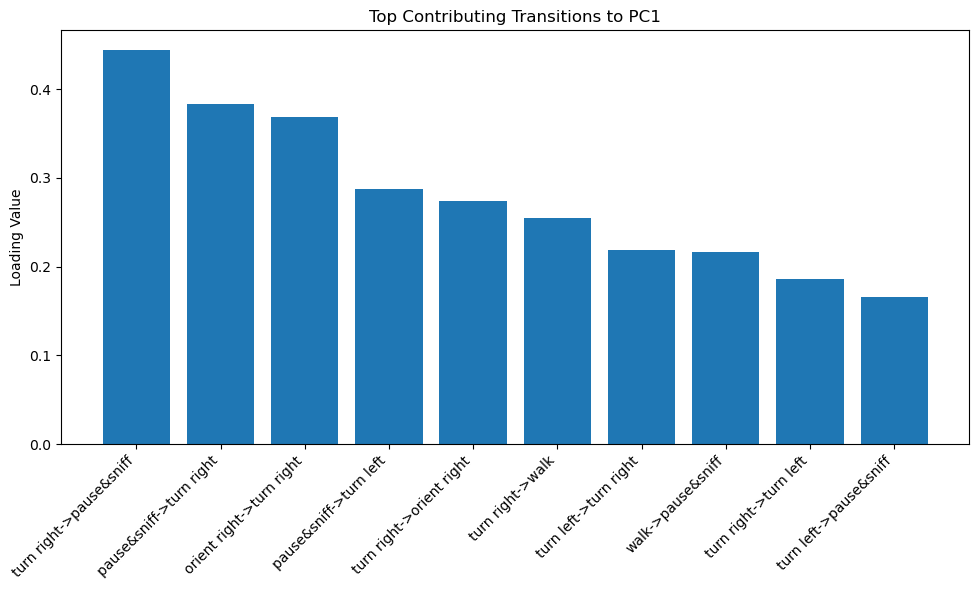

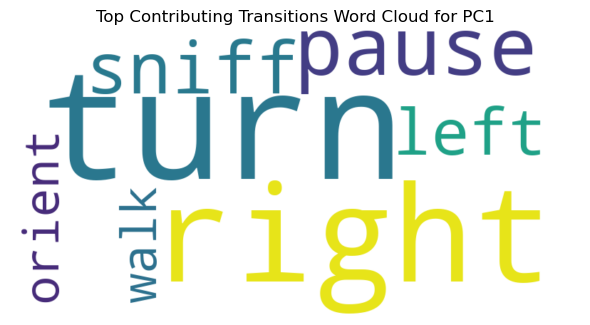

##############################


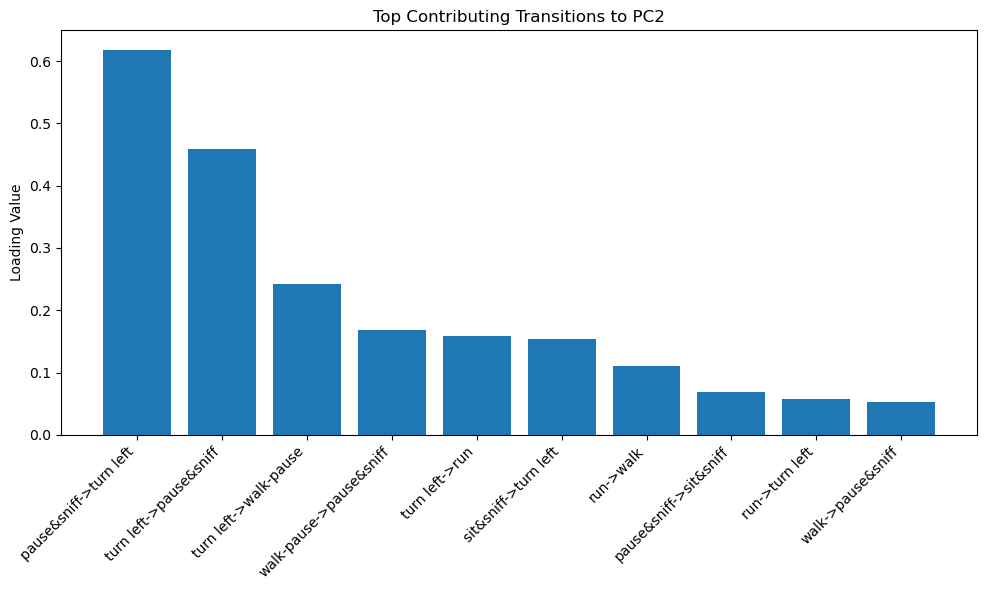

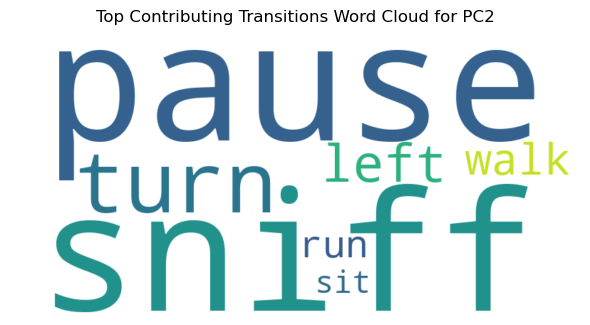

##############################


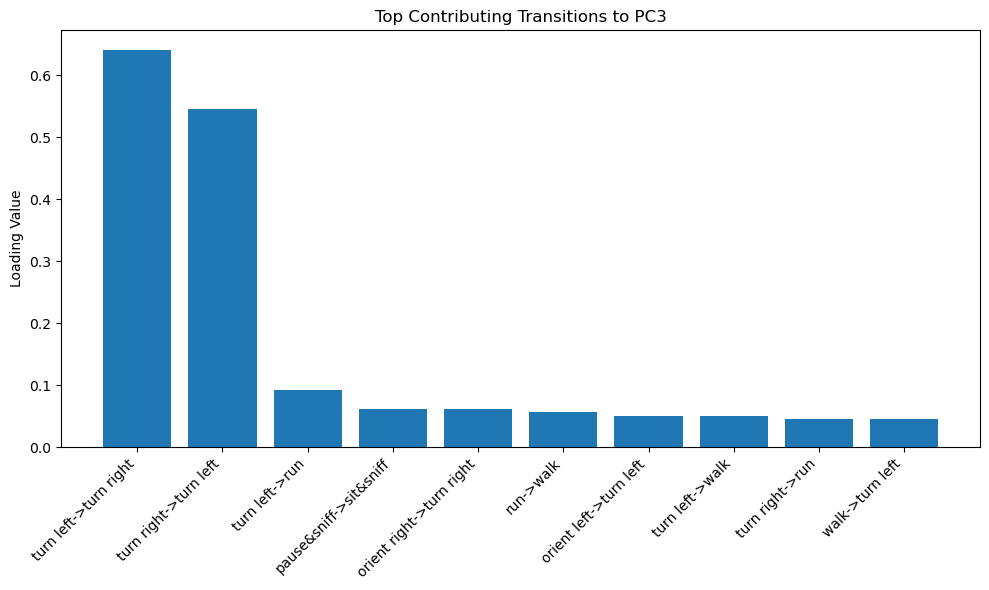

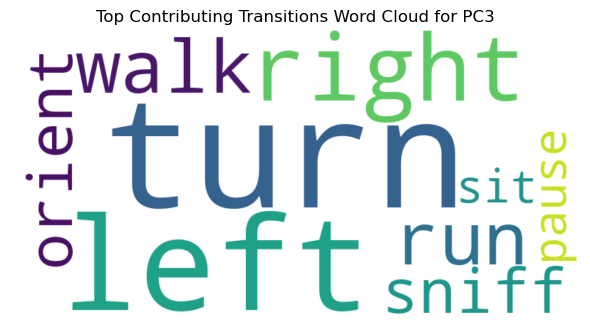

##############################


In [39]:
import re
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming `loadings` is an array with loadings for each principal component
# and `features` contains the feature names (syllable transitions)

# Create a function to prepare transition strings and count word frequencies
def prepare_transitions(transitions):
    """Prepares the transition strings by joining, replacing non-letter characters with spaces, and counting word frequencies."""
    # Join all transitions into one string
    transition_string = ' '.join(transitions)
    # Replace non-letter characters (like '->') with spaces
    transition_string = re.sub(r'[^a-zA-Z]+', ' ', transition_string)
    # Split the string into individual words
    words = transition_string.split()
    # Count word frequencies
    word_frequencies = Counter(words)
    return word_frequencies

# Loop over the first three principal components
for i in range(3):  # For PC1, PC2, PC3
    pc_index = i  # Index of the PC to analyze (0 for PC1)
    sorted_indices = np.argsort(loadings[pc_index])[::-1]
    top_features = [features[i] for i in sorted_indices[:10]]  # Top 10 features
    
    # Add bar plot for top features (transitions) with their loading values
    plt.figure(figsize=(10, 6))
    plt.bar(top_features, loadings[pc_index][sorted_indices[:10]])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Loading Value')
    plt.title(f'Top Contributing Transitions to PC{i+1}')
    plt.tight_layout()
    plt.show()
    
    # Prepare word frequency dictionary
    word_frequencies = prepare_transitions(top_features)
    
    # Generate word cloud using word frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
    
    # Display the word cloud
    plt.figure(figsize=(6, 4.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Top Contributing Transitions Word Cloud for PC{i+1}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print('#'*30)


Interestingly the PCs automatically get split into a right- and left turn transition PC.

We look at the syllables that are actually used in the top 10 features of the pcs

In [165]:
all_used_features

set()

In [31]:
set(df_example.index) - all_used_features

{'sniff left', 'sniff right', 'walk'}

Interestingly "sniff left", "sniff right" and "walk" are not present. Maybe they can be discarded?

In [40]:
# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['Label'] = total_labels
pca_df['Mouse_id'] = pca_df['Label'].apply(lambda x: x.split()[0])
pca_df['Condition'] = pca_df['Label'].apply(lambda x: x.split()[1])
pca_df['Genotype'] = pca_df['Label'].apply(lambda x: x.split()[2])
pca_df['Side'] = pca_df['Label'].apply(lambda x: x.split()[3])

In [41]:
pca_df

,PC1,PC2,PC3,Label,Mouse_id,Condition,Genotype,Side
0,-252.954949,-69.280762,15.116934,222 pre Het Left,222,pre,Het,Left
1,682.071004,-524.541467,-160.080558,222 post Het Left,222,post,Het,Left
2,-282.303515,-89.757282,25.379550,214 pre WT Left,214,pre,WT,Left
3,55.959988,-161.017405,-114.215354,214 post WT Left,214,post,WT,Left
4,-259.771061,-77.091662,12.513171,237 pre Het Left,237,pre,Het,Left
5,416.474244,-360.487371,-239.046970,237 post Het Left,237,post,Het,Left
6,-251.321036,-73.465439,-4.131393,218 pre Het Left,218,pre,Het,Left
7,374.676079,251.645928,-208.329434,218 post Het Left,218,post,Het,Left
8,-254.090905,-76.277332,6.145939,210 pre WT Left,210,pre,WT,Left
9,-152.115701,-27.239522,-30.261635,210 post WT Left,210,post,WT,Left


In [42]:
# Define feature names (transitions)
syllables = grouped_transitions[('222', 'pre', 'Het', 'Left')][0].index.tolist()
next_syllables = grouped_transitions[('222', 'pre', 'Het', 'Left')][0].columns.tolist()
features = [f'{current}->{next_}' for current in syllables for next_ in next_syllables]

In [43]:
# Extract PCA loadings and scale them
loadings = pca.components_.T  # Shape: (n_features, n_components)
scaling_factors = np.sqrt(pca.explained_variance_)
loadings_scaled = loadings * scaling_factors

In [44]:
# Identify top N features for PC1 and PC2
N = 10
top_pc1_indices = np.argsort(np.abs(loadings_scaled[:, 0]))[::-1][:N]
top_pc2_indices = np.argsort(np.abs(loadings_scaled[:, 1]))[::-1][:N]
top_pc3_indices = np.argsort(np.abs(loadings_scaled[:, 1]))[::-1][:N]
top_indices = np.unique(np.concatenate((top_pc1_indices, top_pc2_indices)))

# # Biplot with selective annotations
# plt.figure(figsize=(12, 10))
# sns.scatterplot(
#     x='PC1', y='PC2',
#     data=pca_df,
#     hue='Genotype',
#     style='Condition',
#     s=100,
#     palette='deep'
# )

# # Plot scaled loading vectors for selected top features
# for i in top_indices:
#     plt.arrow(
#         0, 0,
#         loadings_scaled[i, 0],
#         loadings_scaled[i, 1],
#         color='r', alpha=0.5, head_width=0.05, head_length=0.1
#     )
#     plt.text(
#         loadings_scaled[i, 0]*1.15,
#         loadings_scaled[i, 1]*1.15,
#         features[i],
#         color='g', ha='center', va='center', fontsize=10
#     )

# plt.title('PCA Biplot with Top Transition Loadings')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')

# # Custom legend
# handles, labels_ = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels_, handles))
# plt.legend(by_label.values(), by_label.keys(), title='Genotype and Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [45]:
import plotly.graph_objects as go

# Define colors for Genotype and Condition combinations
genotype_condition_colors = {
    ('Het', 'pre'): 'blue',
    ('Het', 'post'): 'cyan',
    ('WT', 'pre'): 'orange',
    ('WT', 'post'): 'yellow'
}

# Define symbols for Side
side_symbols = {'Left': 'circle', 'Right': 'diamond'}

# Scaling factor for biplot vectors
scale_factor = 5  # Adjust this value to control the length of the biplot lines

# Initialize the figure
fig = go.Figure()

# Calculate the clockwise displacement for each label and add it to the DataFrame
pca_df['CW_Displacement'] = pca_df['Label'].apply(lambda label: -dfs_split[tuple(label.split())]['angular_velocity_clean'].sum() / 6.28)

# Add scatter points for PCA scores, including CW displacement in hover text
for genotype in pca_df['Genotype'].unique():
    for condition in pca_df['Condition'].unique():
        for side in pca_df['Side'].unique():
            subset = pca_df[(pca_df['Genotype'] == genotype) & 
                            (pca_df['Condition'] == condition) & 
                            (pca_df['Side'] == side)]
            
            fig.add_trace(
                go.Scatter(
                    x=subset['PC1'],
                    y=subset['PC2'],
                    mode='markers',
                    marker=dict(
                        size=12,
                        color=genotype_condition_colors[(genotype, condition)],
                        symbol=side_symbols[side]
                    ),
                    name=f'{genotype} {condition} {side}',
                    text=subset['Label'],  # Assuming 'Label' contains additional info to display on hover
                    hovertemplate=(
                        "<b>Genotype:</b> %{marker.color}<br>"
                        "<b>Condition:</b> %{text}<br>"
                        "<b>Side:</b> %{symbol}<br>"
                        "<b>CW Displacement:</b> %{customdata:.2f} rotations<br>"
                        "PC1: %{x:.2f}<br>"
                        "PC2: %{y:.2f}<br>"
                    )
,
                    customdata=subset['CW_Displacement'],  # Add CW displacement to customdata for hover
                    showlegend=True
                )
            )

# Plot scaled loading vectors for selected top features with custom scaling
for i in top_indices:
    fig.add_trace(
        go.Scatter(
            x=[0, loadings_scaled[i, 0] * scale_factor],
            y=[0, loadings_scaled[i, 1] * scale_factor],
            mode='lines+markers',
            line=dict(color='red', width=2),
            marker=dict(size=5, color='red'),
            name=features[i],
            text=[None, features[i]],
            hoverinfo='text',  # Only show feature name on hover
            showlegend=False  # Hide from legend
        )
    )

# Add labels for the loading vectors at the exact tip of the arrows
for i in top_indices:
    fig.add_annotation(
        x=loadings_scaled[i, 0] * scale_factor,  # Place label at arrow tip (x-coordinate)
        y=loadings_scaled[i, 1] * scale_factor,  # Place label at arrow tip (y-coordinate)
        text=features[i],
        showarrow=False,  # No need for a separate arrow since it's already pointing at the label
        font=dict(color="green", size=10),
        xanchor="center",  # Center the label horizontally
        yanchor="middle"   # Center the label vertically
    )

# Customize the layout
fig.update_layout(
    title='PCA Biplot with Scaled Transition Loadings and CW Displacement',
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    legend_title_text='Genotype, Condition, and Side',
    width=900, height=700,
    hovermode='closest'
)

# Show the figure
fig.show()


In [46]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data
X = data  # Flattened transition matrices
y = pca_df[['Genotype', 'Condition']]

In [47]:
y_short = y[y['Condition'] == 'post']
X_short = X[y['Condition'] == 'post']

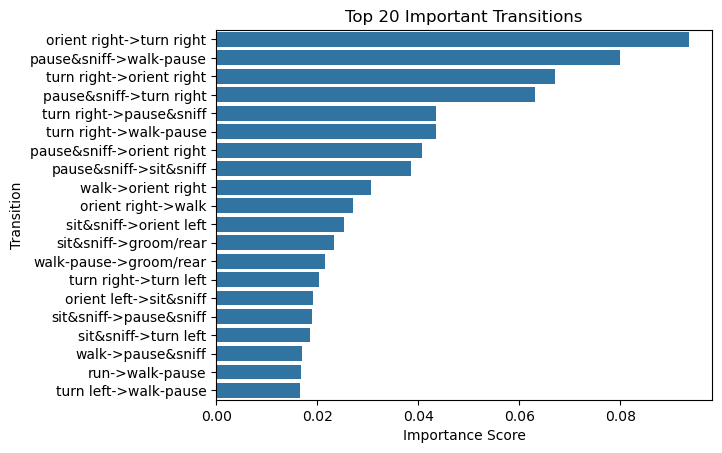

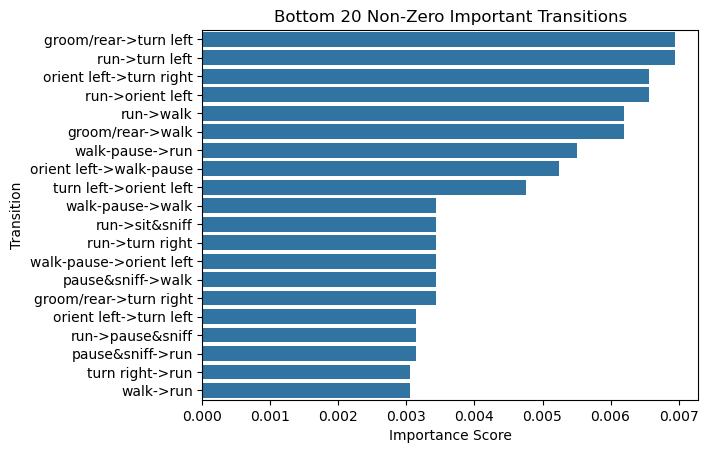

In [49]:
import seaborn as sns

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_short, y_short)

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)

# Plot top N important features
top_n = 20
sns.barplot(x=feature_importances.head(top_n), y=feature_importances.head(top_n).index)
plt.title(f'Top {top_n} Important Transitions')
plt.xlabel('Importance Score')
plt.ylabel('Transition')
plt.show()

# Filter out zero importance features
non_zero_importances = feature_importances[feature_importances > 0]

# Plot bottom N non-zero important features
bottom_n = 20  # You can adjust the number to show
sns.barplot(x=non_zero_importances.tail(bottom_n), y=non_zero_importances.tail(bottom_n).index)
plt.title(f'Bottom {bottom_n} Non-Zero Important Transitions')
plt.xlabel('Importance Score')
plt.ylabel('Transition')
plt.show()

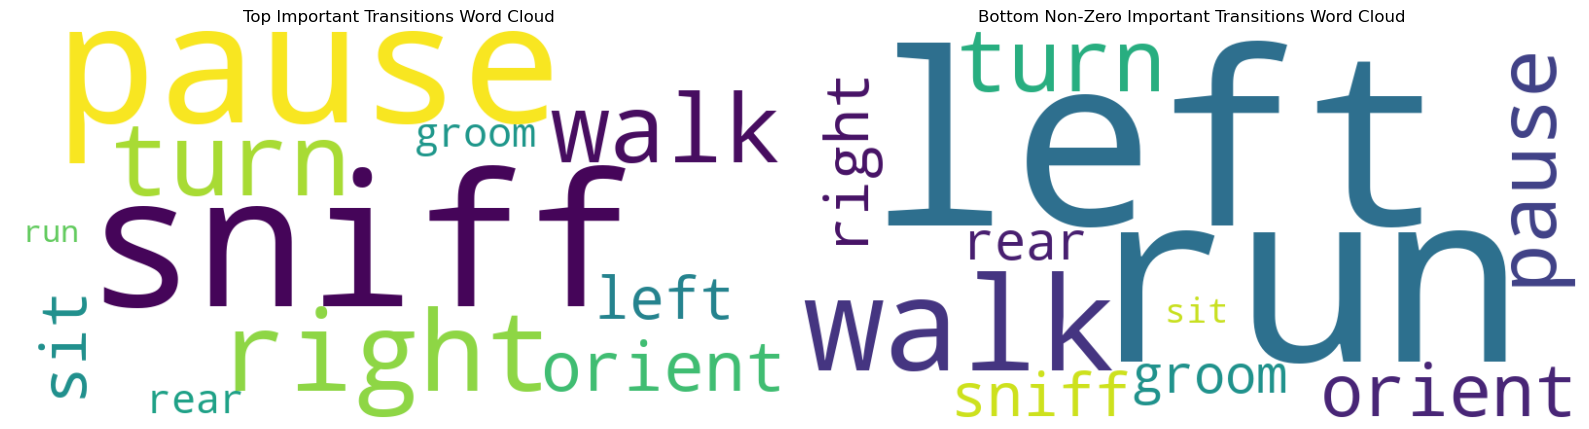

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_short, y_short)

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)

# Filter top and bottom non-zero important transitions
top_n = 20
bottom_n = 20

# Top transitions
top_transitions = feature_importances.head(top_n).index
# Bottom non-zero transitions
non_zero_importances = feature_importances[feature_importances > 0]
bottom_transitions = non_zero_importances.tail(bottom_n).index

# Create a function to prepare transition strings
def prepare_transitions(transitions):
    return ' '.join(' '.join(transition.split('->')) for transition in transitions)

# Prepare strings for word clouds
top_transition_string = prepare_transitions(top_transitions)
bottom_transition_string = prepare_transitions(bottom_transitions)

# Generate word clouds
wordcloud_top = WordCloud(width=800, height=400, background_color='white').generate(top_transition_string)
wordcloud_bottom = WordCloud(width=800, height=400, background_color='white').generate(bottom_transition_string)

# Display the word clouds
plt.figure(figsize=(16, 8))

# Top transitions word cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_top, interpolation='bilinear')
plt.title('Top Important Transitions Word Cloud')
plt.axis('off')

# Bottom transitions word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_bottom, interpolation='bilinear')
plt.title('Bottom Non-Zero Important Transitions Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()

In [51]:
mouse_info

,Genotype,shRNAhemis,PreInjStart,PreInjEnd,PostInjStart,PostInjEnd
MouseID,,,,,,
237,Het,Left,2.00,62.00,64,154
239,Het,Left,4.00,64.00,66,156
243,WT,Right,5.00,65.00,68,158
202,Het,Right,5.00,65.00,70,160
206,WT,Left,4.00,64.00,68,158
208,WT,Right,7.00,67.00,70,160
210,WT,Left,2.00,62.00,65,155
214,WT,Left,0.45,60.45,62,152
218,Het,Left,3.00,63.00,66,156


In [52]:
gen_side_counts = defaultdict(int)

In [53]:
for _, row in mouse_info.iterrows():
    idx = tuple(row[['Genotype', 'shRNAhemis']])
    gen_side_counts[idx] += 1


for k, v in gen_side_counts.items():
    print(k, v)

('Het', 'Left') 4
('WT', 'Right') 2
('Het', 'Right') 2
('WT', 'Left') 3


In [54]:
gen_side_counts

defaultdict(int,
            {('Het', 'Left'): 4,
             ('WT', 'Right'): 2,
             ('Het', 'Right'): 2,
             ('WT', 'Left'): 3})

In [55]:
mouse_info

,Genotype,shRNAhemis,PreInjStart,PreInjEnd,PostInjStart,PostInjEnd
MouseID,,,,,,
237,Het,Left,2.00,62.00,64,154
239,Het,Left,4.00,64.00,66,156
243,WT,Right,5.00,65.00,68,158
202,Het,Right,5.00,65.00,70,160
206,WT,Left,4.00,64.00,68,158
208,WT,Right,7.00,67.00,70,160
210,WT,Left,2.00,62.00,65,155
214,WT,Left,0.45,60.45,62,152
218,Het,Left,3.00,63.00,66,156
